<a href="https://colab.research.google.com/github/Mohammadi-Nilofer/Tesla_stock_price/blob/main/Tesla_Stockprice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Time Series- Tesla stock price forecasting

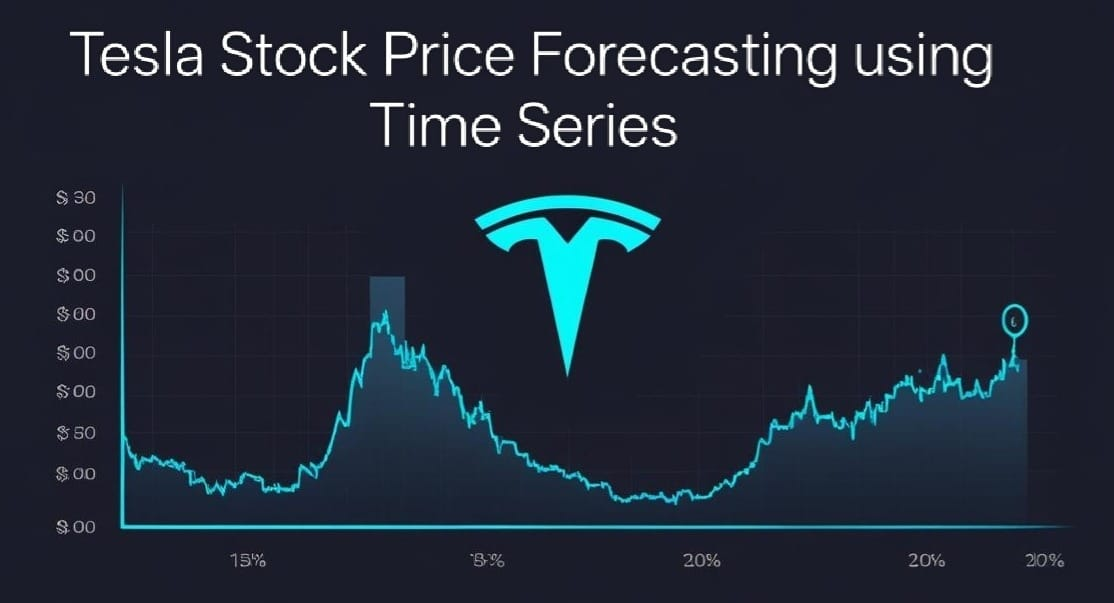

#Context:

What is TESLA?
Tesla, Inc. is an American electric vehicle and clean energy company based in Palo Alto, California. Tesla's current products include electric cars, battery energy storage from home to grid-scale, solar panels and solar roof tiles, as well as other related products and services.

#Objective:

To predict Tesla's future stock price to help with investment decisions.


#Data Dictionary:

This dataset provides historical data of TESLA INC. stock (TSLA), obtained from Yahoo Finance.The data is available at a daily level. Currency is USD.

#Installing all necessary libraries

In [ ]:
#Installing required libraries
!pip install yFinance statsmodels matplotlib pandas

#Importing necessary libraries

In [ ]:
#Importing necessary libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')


#Loading the data

In [ ]:
#Getting the data
Tesla_data = yf.download('TSLA', start = "2015-01-01", end = "2025-07-15", interval = "1mo")
Tesla_data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2015-01-01,13.573333,14.883333,12.333333,14.858000,1353076500
2015-02-01,13.556000,15.032000,12.885333,13.598000,1600762500
2015-03-01,12.584667,13.746000,12.093333,13.513333,1844851500
2015-04-01,15.070000,15.916667,12.403333,12.580000,1484176500
2015-05-01,16.719999,16.858000,14.683333,15.329333,1336917000


#Exploring data

In [ ]:
Tesla_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 127 entries, 2015-01-01 to 2025-07-01
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, TSLA)   127 non-null    float64
 1   (High, TSLA)    127 non-null    float64
 2   (Low, TSLA)     127 non-null    float64
 3   (Open, TSLA)    127 non-null    float64
 4   (Volume, TSLA)  127 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


**Observations:**

* Date column is already in datetime format and is present as index.

#checking for missing values

In [ ]:
Tesla_data.isnull().sum()

,,0
Price,Ticker,
Close,TSLA,0
High,TSLA,0
Low,TSLA,0
Open,TSLA,0
Volume,TSLA,0


**Observations:

*There are no null values

In [ ]:
#Keeping only closing price

Tesla= Tesla_data[['Close']].copy()
Tesla.columns=['Price']
Tesla.head()

,Price
Date,
2015-01-01,13.573333
2015-02-01,13.556000
2015-03-01,12.584667
2015-04-01,15.070000
2015-05-01,16.719999


#Summary statistics

In [ ]:
Tesla.describe()

,Price
count,127.000000
mean,129.094341
std,122.437019
min,12.344000
25%,17.742667
50%,52.125332
75%,235.851662
max,404.600006


#Visualizing the closing price over time

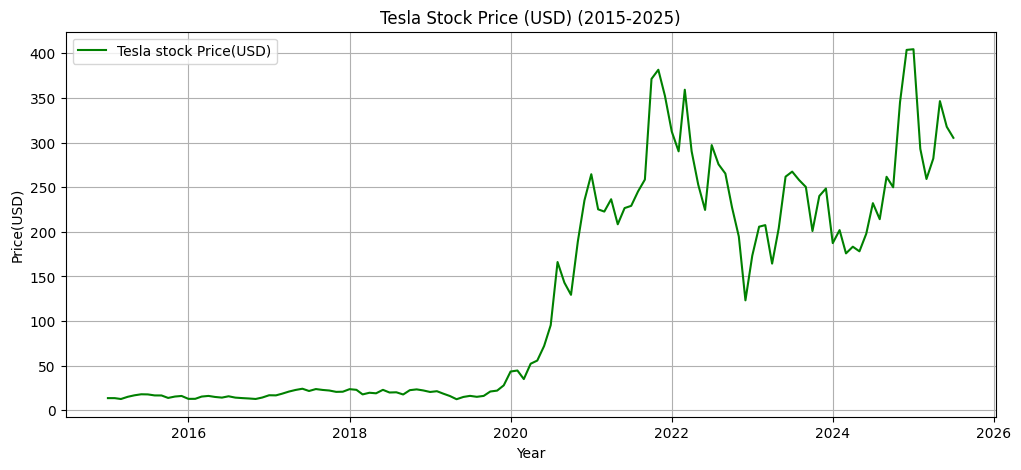

In [ ]:
#Plot
plt.figure(figsize=(12,5))
plt.plot(Tesla, label="Tesla stock Price(USD)", color= 'green')
plt.title('Tesla Stock Price (USD) (2015-2025)')
plt.xlabel('Year')
plt.ylabel('Price(USD)')
plt.grid(True)
plt.legend()
plt.show()

**Observations**

* There is a clear and significant upward trend in the stock price over the entire period.
* The plot shows periods of very rapid increase in stock price, particularly in the later years of the dataset.
* The stock price exhibits notable volatility, with both sharp increases and decreases occurring throughout the decade.
* While there are fluctuations, a clear, repeating seasonal pattern is not immediately evident just by visual inspection. so lets go for Seasonality Decomposoition.

#SeasonalDecomposition

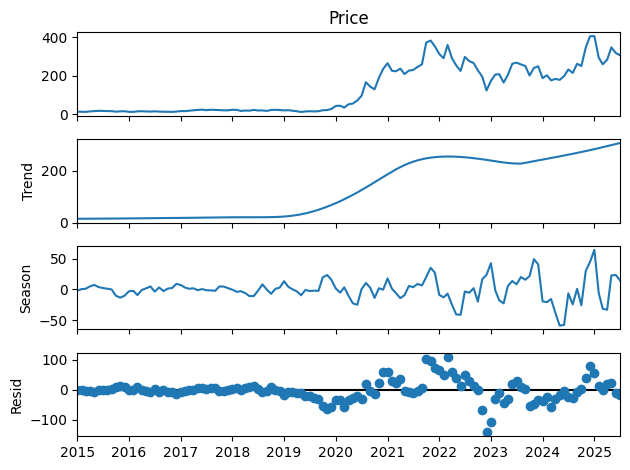

In [ ]:
#STL Decomposition
stl= STL(Tesla['Price'],period=24)
result=stl.fit()
result.plot()
plt.show()

**Observations:**

* Trend: There is a clear, strong upward trend in the stock price over the entire period.
* Seasonality: There is a discernible seasonal pattern, though its magnitude is smaller compared to the trend.
* Residuals: The residuals show the irregular fluctuations in the stock price that are not explained by the trend or seasonality. The variance of the residuals appears to increase over time, indicating increasing volatility.

#Checking Stationarity using ADF test

In [ ]:
#ADF Test for Stationarity
adf_result =adfuller(Tesla['Price'])
print('ADF Statistic: ', adf_result[0])
print('p-value:', adf_result[1])
if adf_result[1] <= 0.05:
  print('\n The series is stationary')
else:
  print('\n The series is non-stationary')

ADF Statistic:  -0.8373449462865533
p-value: 0.8079054536331254

 The series is non-stationary


**Observations:**
Since, the data that we are working with is not stationary,
we cannot use AR, MA, ARMA models  

#Making the data Stationary

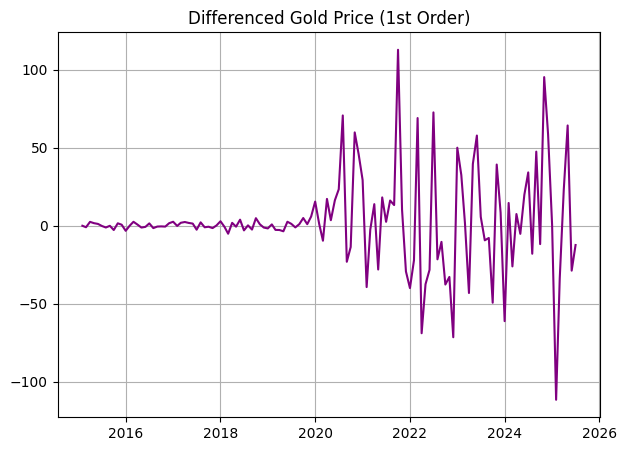

In [ ]:
#Differencing to make series stationary
Tesla_diff =Tesla['Price'].diff().dropna()

plt.figure(figsize=(7,5))
plt.plot(Tesla_diff, label="Tesla Stock Price(USD)", color= 'Purple')
plt.title('Differenced Gold Price (1st Order)')
plt.grid(True)
plt.show()

#ACF and PACF plots

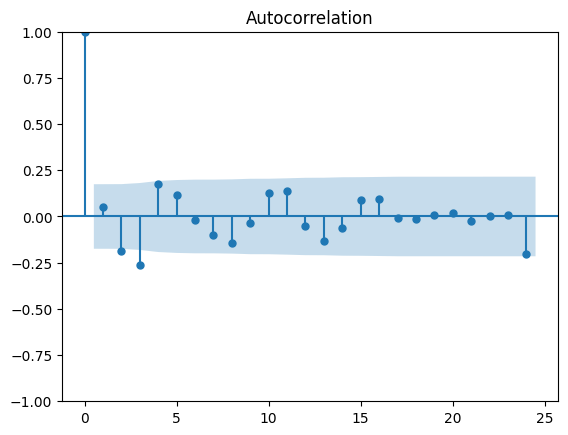

In [ ]:
#ACF plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(Tesla_diff,lags=24)
plt.show()

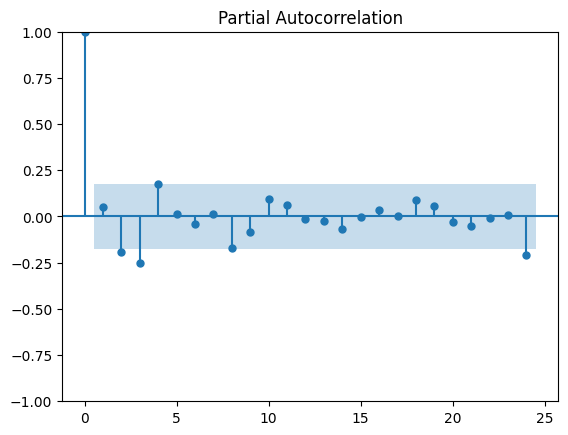

In [ ]:
#PACF plot
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(Tesla_diff,lags=24)
plt.show()

**Observations:**

* The ACF plot shows a gradual decay, but the most significant spike is at lag 1.
* The PACF plot shows a more abrupt cutoff after the initial lags, with the most significant spike also at lag 1.

#Model Building- ARIMA

In [ ]:
#Fitting the ARIMA Model (Basic)

model_arima=ARIMA(Tesla['Price'], order=(1,1,1))
model_arima_fit = model_arima.fit()
print('\n ARIMA Model Summary: \n')
print(model_arima_fit.summary())


 ARIMA Model Summary: 

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  127
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -606.844
Date:                Fri, 25 Jul 2025   AIC                           1219.687
Time:                        23:21:52   BIC                           1228.196
Sample:                    01-01-2015   HQIC                          1223.144
                         - 07-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7220      0.313      2.307      0.021       0.109       1.335
ma.L1         -0.7913      0.276     -2.866      0.004      -1.332      -0.250
sigma2       892.8029     7

#Forecasting for next 12 months

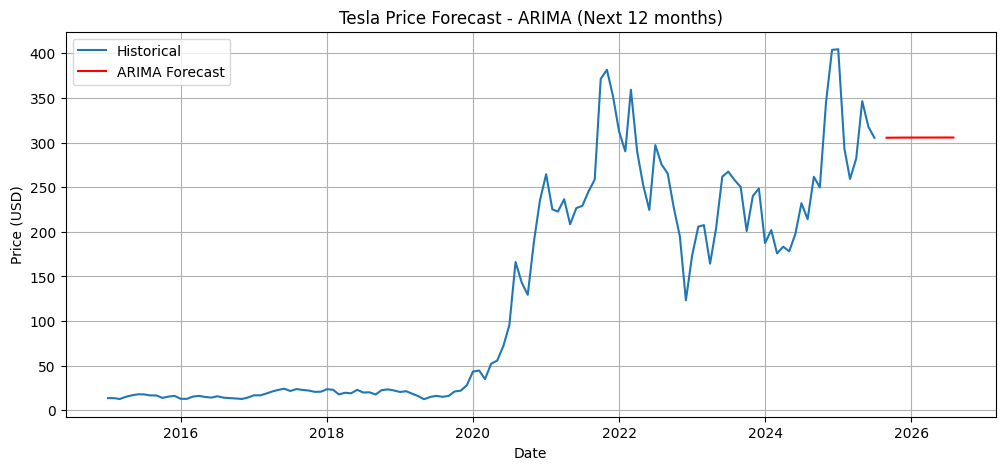

In [ ]:
#Forecasting using ARIMA model
forecast_arima = model_arima_fit.forecast(steps = 12)
forecast_index = pd.date_range(start = Tesla.index[-1] + pd.DateOffset(months = 1),periods = 12 ,freq= 'M')

#Plot
plt.figure(figsize=(12,5))
plt.plot(Tesla['Price'], label = 'Historical')
plt.plot(forecast_index, forecast_arima, label ='ARIMA Forecast', color='red')
plt.title('Tesla Price Forecast - ARIMA (Next 12 months)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.legend()
plt.show()

**Observations:**

* The ARIMA forecast predicts a relatively flat line for the next 12 months.
* The forecast stays close to the last historical data point and does not capture the upward trend or the high volatility seen in the historical data.
* This suggests that the basic ARIMA(1,1,1) model is not effectively capturing the underlying patterns and trend in the Tesla stock price for forecasting this far out.

#Model Building - SARIMA

In [ ]:
#Fitting the SARIMA Model (Basic)
model_sarima=SARIMAX(Tesla['Price'],order=(1,1,1), seasonal_order=(1,1,1,12))
model_sarima_fit = model_sarima.fit()
print('\n ARIMA Model Summary: \n')
print(model_sarima_fit.summary())


 ARIMA Model Summary: 

                                     SARIMAX Results                                      
Dep. Variable:                              Price   No. Observations:                  127
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -565.697
Date:                            Fri, 25 Jul 2025   AIC                           1141.395
Time:                                    23:44:12   BIC                           1155.076
Sample:                                01-01-2015   HQIC                          1146.947
                                     - 07-01-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9996      1.193     -0.838      0.402      -3.339       1.340
ma.L1     

#Forecasting for next 12 months

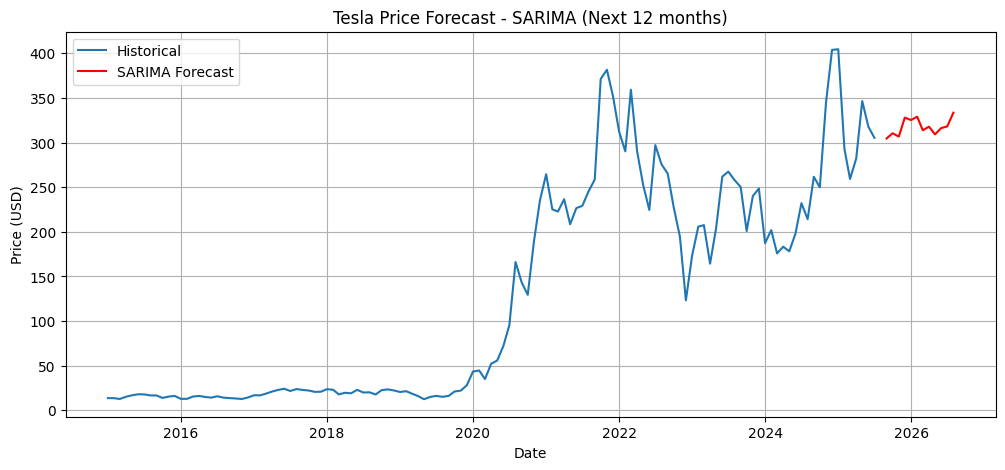

In [ ]:
#Forecasting using SARIMA model
forecast_sarima = model_sarima_fit.forecast(steps = 12)
forecast_index = pd.date_range(start = Tesla.index[-1] + pd.DateOffset(months = 1),periods = 12,freq= 'M')

#Plot
plt.figure(figsize=(12,5))
plt.plot(Tesla['Price'], label = 'Historical')
plt.plot(forecast_index, forecast_sarima, label ='SARIMA Forecast', color='red')
plt.title('Tesla Price Forecast - SARIMA (Next 12 months)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.legend()
plt.show()

#Model Comparision

In [ ]:
#Model Comparision
print('Model Comparision :')
print(f"ARIMA Model AIC: {model_arima_fit.aic}")
print(f"SARIMA Model AIC: {model_sarima_fit.aic}")

#Select model based on lesser AIC
if model_arima_fit.aic < model_sarima_fit.aic:
  print('\n ARIMA Model is selected')
else:
  print('\n SARIMA Model is selected')

Model Comparision :
ARIMA Model AIC: 1219.6873514192853
SARIMA Model AIC: 1141.3947753962295

 SARIMA Model is selected


#Conclusions:

The SARIMA model provides a more reliable forecast of Tesla's stock price for the next 12 months. This information is valuable for investors to make more informed decisions about buying, selling, or holding Tesla stock, helping them manage risk and potential returns.